In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
import random
import warnings
import gc
import time
from IPython.core.display import Image
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [ ]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#提案手法・Multi LGBM
scores2 = pd.read_csv("./output/multi/scores_.csv")
df_test2 = pd.read_csv("./output/multi/df_test2_.csv")
pvrate = pd.read_csv(".data/pv_rate.csv")
test2 = pd.read_csv("./output/multi/test2_.csv")

#既存手法2・LGBM
df_test3 = pd.read_csv("./output/single/df_test3.csv")
test3 = pd.read_csv("./output/single/test3.csv")

In [ ]:
import folium
import pandas as pd
 
place = test2.drop_duplicates(subset=["id"])
 
map = folium.Map(location=[35.78,140.04],
                tiles='stamenterrain',
                zoom_start=10)
 
for i, r in place.iterrows():
  if (r['id_lat_mesh']==35.78) and (r['id_lng_mesh'] == 140.04):
    folium.Marker(location=[r['id_lat_mesh'], r['id_lng_mesh']], popup=r['id'],icon=folium.Icon(color='red')).add_to(map)
  else:
    folium.Marker(location=[r['id_lat_mesh'], r['id_lng_mesh']], popup=r['id'],icon=folium.Icon(color='blue')).add_to(map)
    
# map.save("map_train.html")
map

In [ ]:
test2["ppred2"] = test2["ppred"] / test2["observed_max"]
test2_ = test2[test2.id.isin(df_test2.id.unique())]
test3_ = test3[test3.id.isin(df_test3.id.unique())]

In [ ]:
mape = (np.abs((test2_.loc[test2_.nv2!=0,"pred"] - test2_.loc[test2_.nv2!=0,"nv2"])/test2_.loc[test2_.nv2!=0,"nv2"])).mean()*100
mape_single = (np.abs((test3_.loc[test3_.nv2!=0,"pred"] - test3_.loc[test3_.nv2!=0,"nv2"])/test3_.loc[test3_.nv2!=0,"nv2"])).mean()*100
mape_op = (np.abs((test2_.loc[test2_.nv2!=0,"ppred2"] - test2_.loc[test2_.nv2!=0,"nv2"])/test2_.loc[test2_.nv2!=0,"nv2"])).mean()*100

rmse = np.sqrt(mean_squared_error(test2_["nv2"], test2_["pred"]))
rmse_single = np.sqrt(mean_squared_error(test3_["nv2"], test3_["pred"]))
rmse_op = np.sqrt(mean_squared_error(test2_["nv2"], test2_["ppred2"]))
print(f"オプティカルフロー:{rmse_op}",f"LGBM:{rmse_single}",f"multi LGBM:{rmse}")

オプティカルフロー:0.10371715197128704 LGBM:0.0973886505685773 multi LGBM:0.084518383059735


In [ ]:
mape = (np.abs((test2_["pred"] - test2_["nv2"])/(test2["pvrate"]*1000/test2["observed_max"]))).mean()*100
mape_single = (np.abs((test3_["pred"] - test3_["nv2"])/(test3["pvrate"]*1000/test3["observed_max"]))).mean()*100
mape_op = (np.abs((test2_["ppred2"] - test2_["nv2"])/(test2["pvrate"]*1000/test2["observed_max"]))).mean()*100
print(f"オプティカルフロー:{mape_op}",f"LGBM:{mape_single}",f"multi LGBM:{mape}")

オプティカルフロー:5.658865525464218 LGBM:5.547676911042099 multi LGBM:4.723689456800974


In [ ]:
scores = pd.DataFrame(columns=["オプティカルフロー","LGBM","multi LGBM"],index=["rmse[%]","mape[%]"])
scores.iloc[0] = [rmse_op,rmse_single,rmse]
scores.iloc[0] = scores.iloc[0]*100
scores.iloc[1] = [mape_op,mape_single,mape]

In [ ]:
scores

,オプティカルフロー,LGBM,multi LGBM
rmse[%],10.371715,9.738865,8.451838
mape[%],5.658866,5.547677,4.723689


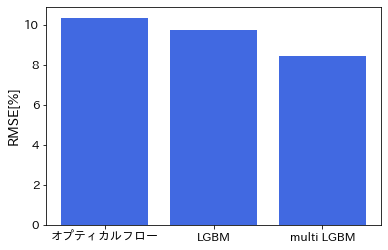

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
 
left = np.array([1, 2, 3])
left = ["オプティカルフロー","LGBM","multi LGBM"]
height =scores.loc["rmse[%]",["オプティカルフロー","LGBM","multi LGBM"]]
plt.bar(left, height,color="royalblue",width=0.8)
#plt.xlabel("xlabel", fontsize=18)
plt.ylabel("RMSE[%]", fontsize=14)
plt.tick_params(labelsize=12)

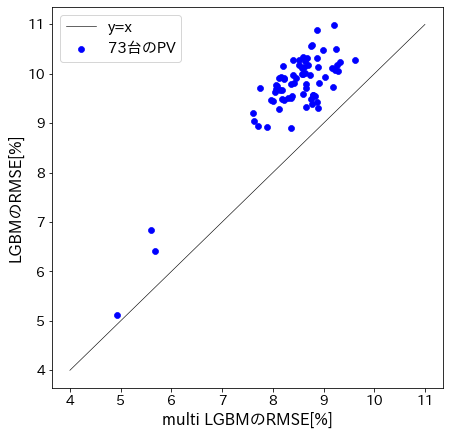

In [ ]:
col = "rmse"
fig = plt.figure(figsize=(7,7))
x,y = list(range(4,12)),list(range(4,12))
#corr = round(df_test4.corr()["missing_percent_train_valid"][col],3)
#plt.scatter(df_test2['fluctuation'],df_test2[col]*100,color="red",label="multi-LGBM stacking")
plt.scatter(df_test2[col]*100,df_test3[col]*100,color="blue",lw=0.7,label="73台のPV")
plt.plot(x,y,label="y=x",color="black",lw=0.6)
plt.xlabel("multi LGBMのRMSE[%]",fontsize=16)
plt.ylabel("LGBMのRMSE[%]",fontsize=16)
plt.legend(fontsize=15)
plt.tick_params(labelsize=14)
#plt.title(f"{col} corr:{corr}")
plt.show()

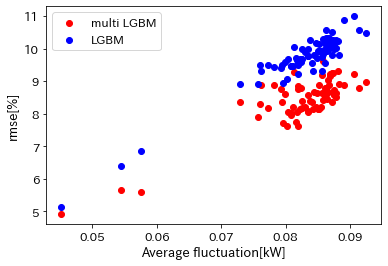

In [ ]:
col = "rmse"
fig = plt.figure()
#corr = round(df_test4.corr()["missing_percent_train_valid"][col],3)
plt.scatter(df_test2['fluctuation'],df_test2[col]*100,color="red",label="multi LGBM")
plt.scatter(df_test3['fluctuation'],df_test3[col]*100,color="blue",label="LGBM")
plt.xlabel("Average fluctuation[kW]",fontsize=13)
plt.ylabel(col+"[%]",fontsize=13)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
#plt.title(f"{col} corr:{corr}")
plt.show()